# 학습모델 개선하는 방법
1. Weight initialization
2. Activation Function
3. Optimizer

In [1]:
from tensorflow.keras.models     import Sequential 
from tensorflow.keras.layers     import Activation , Dense , BatchNormalization , Dropout
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.utils      import plot_model , to_categorical
from tensorflow.keras.callbacks  import EarlyStopping , ModelCheckpoint

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import StandardScaler , MinMaxScaler , LabelEncoder
from sklearn.datasets            import load_breast_cancer
from sklearn.model_selection     import KFold
from sklearn.ensemble            import VotingClassifier
from sklearn.metrics             import accuracy_score



import matplotlib.pyplot as plt

import pandas  as pd
import numpy   as np
import seaborn as sns

# dataset
from tensorflow.keras.datasets.mnist import load_data


In [2]:
(X_train, y_train),(X_test,y_test) = load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
X_train = X_train.reshape((X_train.shape[0],-1))
X_test = X_test.reshape((X_test.shape[0],-1))

In [4]:
# 원-핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

In [6]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [7]:
# 모델생성하는 함수 만들기
def get_mnist_model():
  model = Sequential()

  model.add( Dense(50, activation = 'sigmoid', input_shape = (784, ) ) ) # 입력층

  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층1
  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층2
  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층3

  model.add( Dense(10, activation = 'softmax' ) )
  return model

# 전체데이터의 30%만 가져와서 학습데이터로 사용해보자

In [8]:
# 학습모델 개선을 위해서 전체 데이터가 아닌 일부의 데이터를 이용해서 학습 데이터를 만들어 보자!

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.7, random_state = 100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18000, 784), (42000, 784), (18000, 10), (42000, 10))

In [9]:
# 모델 학습전 컴파일

model = get_mnist_model()
optimizer = SGD(learning_rate=0.01)
model.compile(optimizer = optimizer,
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 2.3931 - accuracy: 0.0984 - val_loss: 2.3255 - val_accuracy: 0.1065
Epoch 2/100
50/50 [==============================] - 0s 5ms/step - loss: 2.3174 - accuracy: 0.0952 - val_loss: 2.3027 - val_accuracy: 0.1065
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3032 - accuracy: 0.1085 - val_loss: 2.3000 - val_accuracy: 0.1117
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3005 - accuracy: 0.1152 - val_loss: 2.2998 - val_accuracy: 0.1117
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2997 - accuracy: 0.1152 - val_loss: 2.2997 - val_accuracy: 0.1117
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2993 - accuracy: 0.1152 - val_loss: 2.2997 - val_accuracy: 0.1117
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2989 - accuracy: 0.1152 - val_loss: 2.2994 - val_accuracy: 0.1117
Epoch 8/100


In [11]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

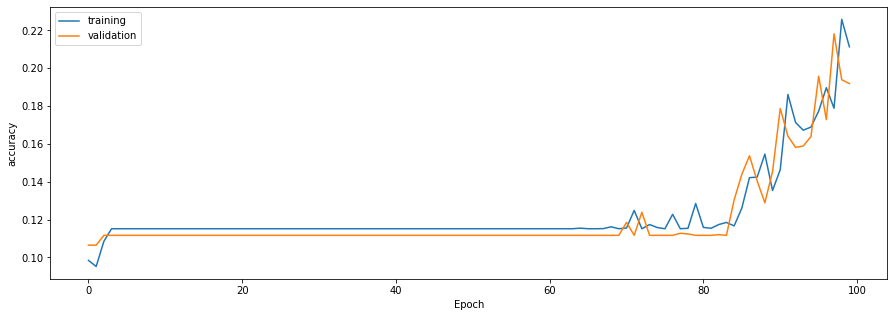

In [12]:
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

In [13]:
# 모델 평가하기
model_eval = model.evaluate(X_test,y_test)
print(model_eval[1]) # 정확도만 추출

1313/1313 [==============================] - 2s 1ms/step - loss: 2.2451 - accuracy: 0.2013
0.20133332908153534


## 가중치 초기화
- LeCun
- Xaiver
- He-Normal

In [14]:
# Sigmoid, Tanh - > Xaiver(glorot_normal) , relu -> he_normal과 매칭시키는게 좋음
# 가중치를 초기화시켜줄 함수 + 컴파일까지
def get_mnist_weight_initialization_model():
  model = Sequential()

  model.add( Dense(50, activation = 'sigmoid', input_shape = (784, ), kernel_initializer='he_normal' ) ) # 입력층

  model.add( Dense(50, activation = 'sigmoid', kernel_initializer='he_normal' ) ) # 은닉층1
  model.add( Dense(50, activation = 'sigmoid', kernel_initializer='he_normal' ) ) # 은닉층2
  model.add( Dense(50, activation = 'sigmoid', kernel_initializer='he_normal' ) ) # 은닉층3

  model.add( Dense(10, activation = 'softmax' ) )

  model.compile(optimizer = SGD(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [15]:
model = get_mnist_weight_initialization_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18000, 784), (42000, 784), (18000, 10), (42000, 10))

In [17]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 1s 8ms/step - loss: 2.4147 - accuracy: 0.0987 - val_loss: 2.3391 - val_accuracy: 0.1048
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3184 - accuracy: 0.1036 - val_loss: 2.3044 - val_accuracy: 0.1385
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3002 - accuracy: 0.1291 - val_loss: 2.2976 - val_accuracy: 0.1111
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2962 - accuracy: 0.1151 - val_loss: 2.2957 - val_accuracy: 0.1117
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2945 - accuracy: 0.1152 - val_loss: 2.2946 - val_accuracy: 0.1117
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2934 - accuracy: 0.1156 - val_loss: 2.2937 - val_accuracy: 0.1117
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2924 - accuracy: 0.1152 - val_loss: 2.2926 - val_accuracy: 0.1117
Epoch 8/100
5

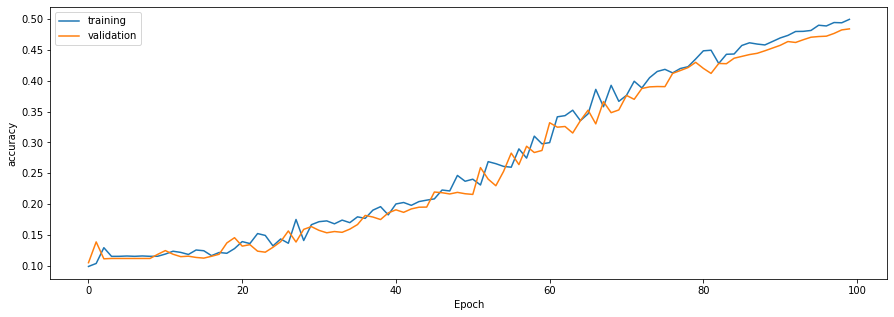

In [18]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

Xaiver 사용할때 보다 he_normal을 사용할때 더 성능이 좋다고 나왔다.

In [19]:
model_eval = model.evaluate(X_test,y_test)
print(model_eval[1])

1313/1313 [==============================] - 2s 1ms/step - loss: 1.8234 - accuracy: 0.4968
0.4967857003211975


## 활성화 함수를 변경해서 성능확인



In [20]:
def get_mnist_activation_model():
  model = Sequential()

  model.add( Dense(50, activation = 'relu', input_shape = (784, )) ) # 입력층

  model.add( Dense(50, activation = 'relu' ) ) # 은닉층1
  model.add( Dense(50, activation = 'relu' ) ) # 은닉층2
  model.add( Dense(50, activation = 'relu' ) ) # 은닉층3

  model.add( Dense(10, activation = 'softmax' ) )

  model.compile(optimizer = SGD(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [21]:
model = get_mnist_activation_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                510       
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 1s 9ms/step - loss: 20.4830 - accuracy: 0.1113 - val_loss: 2.3135 - val_accuracy: 0.1137
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 2.3142 - accuracy: 0.1184 - val_loss: 2.3139 - val_accuracy: 0.1119
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2981 - accuracy: 0.1183 - val_loss: 2.3059 - val_accuracy: 0.1143
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 2.2918 - accuracy: 0.1223 - val_loss: 2.2549 - val_accuracy: 0.1415
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 2.1811 - accuracy: 0.1790 - val_loss: 2.1910 - val_accuracy: 0.1774
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: 2.1389 - accuracy: 0.1944 - val_loss: 2.1682 - val_accuracy: 0.1846
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: 2.1313 - accuracy: 0.1949 - val_loss: 2.1378 - val_accuracy: 0.1941
Epoch 8/100


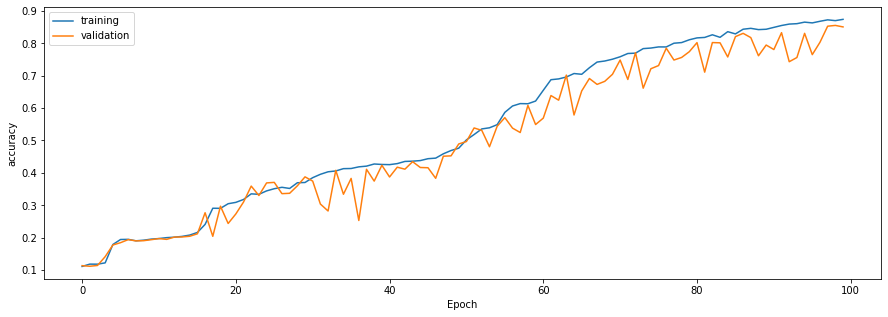

In [23]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

## 옵티마이저를 변경해서 성능확인

In [24]:
def get_mnist_optimizer_model():
  model = Sequential()

  model.add( Dense(50, activation = 'sigmoid', input_shape = (784, )) ) # 입력층

  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층1
  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층2
  model.add( Dense(50, activation = 'sigmoid' ) ) # 은닉층3

  model.add( Dense(10, activation = 'softmax' ) )

  model.compile(optimizer = Adam(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [25]:
model = get_mnist_optimizer_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                510       
Total params: 47,410
Trainable params: 47,410
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 2.0280 - accuracy: 0.2637 - val_loss: 1.5638 - val_accuracy: 0.4789
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: 1.2854 - accuracy: 0.5357 - val_loss: 1.1516 - val_accuracy: 0.5872
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 1.1028 - accuracy: 0.5732 - val_loss: 1.0707 - val_accuracy: 0.5720
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: 1.0103 - accuracy: 0.6251 - val_loss: 1.0492 - val_accuracy: 0.6252
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: 1.0199 - accuracy: 0.6329 - val_loss: 1.0606 - val_accuracy: 0.6446
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 0.9999 - accuracy: 0.6407 - val_loss: 1.0626 - val_accuracy: 0.6224
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 1.0116 - accuracy: 0.6437 - val_loss: 0.9652 - val_accuracy: 0.6720
Epoch 8/100


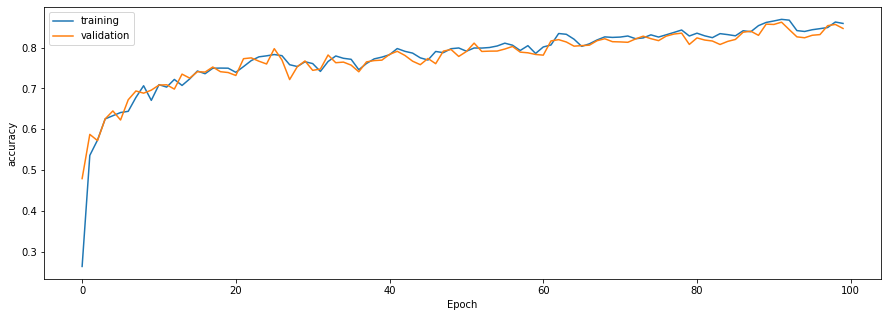

In [27]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

In [28]:
model_eval = model.evaluate(X_test,y_test)
print(model_eval[1])

1313/1313 [==============================] - 2s 1ms/step - loss: 0.4980 - accuracy: 0.8404
0.8404285907745361


## 배치정규화
- 평균 0, 분산 1 정규화를 통해서 학습이 잘 일어나도록 도와주는 방식
- 각 피처별 배치정규화를 진행

In [29]:
def get_mnist_normalization_model():
  model = Sequential()

  model.add( Dense(50, input_shape = (784, )) ) # 입력층
  model.add( BatchNormalization())
  model.add( Activation ('sigmoid')  )  
  
  model.add(Dense(50)) # 은닉층1
  model.add( BatchNormalization())
  model.add( Activation ('sigmoid')  ) 

  model.add(Dense(50)) # 은닉층2
  model.add( BatchNormalization())
  model.add( Activation ('sigmoid')  ) 

  model.add(Dense(50)) # 은닉층3
  model.add( BatchNormalization())
  model.add( Activation ('sigmoid')  )  

  model.add( Dense(10, activation = 'softmax' ))

  model.compile(optimizer = Adam(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [30]:
model = get_mnist_normalization_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)               

In [31]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 2s 12ms/step - loss: 0.8553 - accuracy: 0.8150 - val_loss: 2.1656 - val_accuracy: 0.0993
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.9085 - val_loss: 2.1670 - val_accuracy: 0.1633
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 0.2514 - accuracy: 0.9252 - val_loss: 1.7160 - val_accuracy: 0.4435
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: 0.1878 - accuracy: 0.9457 - val_loss: 1.4019 - val_accuracy: 0.6387
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: 0.1580 - accuracy: 0.9538 - val_loss: 1.3836 - val_accuracy: 0.7076
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: 0.1341 - accuracy: 0.9591 - val_loss: 1.0015 - val_accuracy: 0.7289
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: 0.1131 - accuracy: 0.9644 - val_loss: 0.8435 - val_accuracy: 0.7454
Epoch 8/100


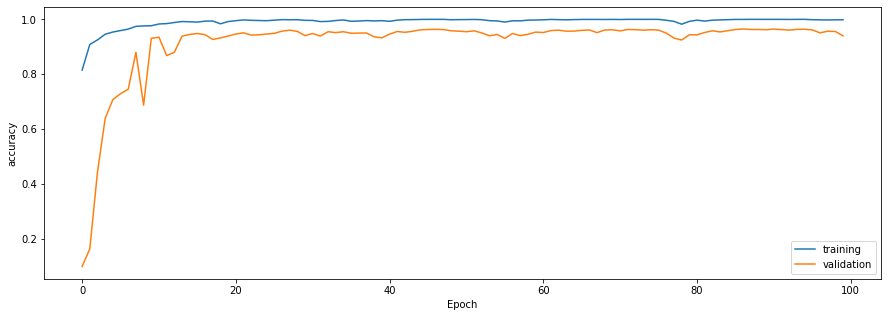

In [32]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

In [33]:
model_eval = model.evaluate(X_test, y_test)
print(model_eval[1])

1313/1313 [==============================] - 2s 2ms/step - loss: 0.3758 - accuracy: 0.9371
0.9370952248573303


## Dropout
- 과대적합(overfitting)을 방지하기 위한 방법이다.
- 배치정규화를 적용하면 내부적으로 규제(regularization)를 포함하고 있어서 Dropout을 적용할 필요가 없다! 
- 학습 정확도가 100%라고 해서 테스트정확도가 높지 않을 수 있다.

In [34]:
# dropout 적용한 함수 
def get_mnist_dropout_model():
  model = Sequential()

  model.add( Dense(50, input_shape = (784, )) ) # 입력층
  model.add( Activation ('sigmoid')  )  
  model.add(Dropout(0.2))

  model.add(Dense(50)) # 은닉층1
  model.add( Activation ('sigmoid')  ) 
  model.add(Dropout(0.2))

  model.add(Dense(50)) # 은닉층2
  model.add( Activation ('sigmoid')  ) 
  model.add(Dropout(0.2))
  
  model.add(Dense(50)) # 은닉층3
  model.add( Activation ('sigmoid')  )  
  model.add(Dropout(0.2))

  model.add( Dense(10, activation = 'softmax' ))

  model.compile(optimizer = Adam(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [35]:
model = get_mnist_dropout_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_4 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_5 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)               

In [36]:
callbacks=[EarlyStopping(monitor = 'val_accuracy',patience=10)]
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=100, verbose=1,callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 1s 10ms/step - loss: 2.1888 - accuracy: 0.1837 - val_loss: 1.6250 - val_accuracy: 0.4280
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: 1.6527 - accuracy: 0.3585 - val_loss: 1.3573 - val_accuracy: 0.4570
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: 1.4901 - accuracy: 0.4316 - val_loss: 1.2231 - val_accuracy: 0.5356
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: 1.4005 - accuracy: 0.4636 - val_loss: 1.1484 - val_accuracy: 0.5698
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: 1.3010 - accuracy: 0.5114 - val_loss: 1.0810 - val_accuracy: 0.5789
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: 1.2263 - accuracy: 0.5452 - val_loss: 0.9884 - val_accuracy: 0.6252
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: 1.1762 - accuracy: 0.5732 - val_loss: 0.9565 - val_accuracy: 0.6833
Epoch 8/100


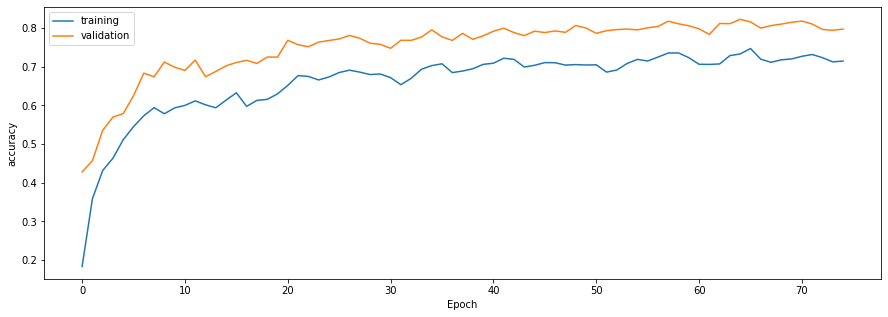

In [37]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

Dropout을 한다고 해서 무조건 성능이 좋아지는건 X,
위의 그래프를 봤을때 과적합이 되지 않은 것으로 판단됨.

In [38]:
model_eval = model.evaluate(X_test, y_test)
print(model_eval[1])

1313/1313 [==============================] - 2s 1ms/step - loss: 0.6264 - accuracy: 0.7960
0.7959761619567871


# 전체학습데이터를 이용해서 신경망 모델을 학습후 검증해보자

In [39]:
# 전체데이터 불러오기
(X_train, y_train),(X_test,y_test) = load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [40]:
X_train = X_train.reshape((X_train.shape[0],-1))
X_test = X_test.reshape((X_test.shape[0],-1))

In [41]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

In [43]:
def get_mnist_mip_model():
  model = Sequential()

  model.add( Dense(50, input_shape = (784, ), kernel_initializer='he_normal') ) # 입력층
  model.add( BatchNormalization() )
  model.add( Activation ('relu')  )  
  model.add(Dropout(0.2))

  model.add(Dense(50, kernel_initializer='he_normal')) # 은닉층1
  model.add( BatchNormalization() )
  model.add( Activation ('relu') ) 
  model.add(Dropout(0.2))

  model.add(Dense(50, kernel_initializer='he_normal')) # 은닉층2
  model.add( BatchNormalization() )
  model.add( Activation ('relu') ) 
  model.add(Dropout(0.2))
  
  model.add(Dense(50, kernel_initializer='he_normal')) # 은닉층3
  model.add( BatchNormalization() )
  model.add( Activation ('relu')  )  
  model.add(Dropout(0.2))

  model.add( Dense(10, activation = 'softmax' ))

  model.compile(optimizer = Adam(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [44]:
model = get_mnist_mip_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
activation_8 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
activation_9 (Activation)    (None, 50)               

In [45]:
model_history = model.fit(X_train, y_train, batch_size=256, validation_split=0.3, epochs=200, verbose=1)

Epoch 1/200
165/165 [==============================] - 3s 10ms/step - loss: 0.6030 - accuracy: 0.8186 - val_loss: 0.2484 - val_accuracy: 0.9334
Epoch 2/200
165/165 [==============================] - 1s 8ms/step - loss: 0.3360 - accuracy: 0.9082 - val_loss: 0.1940 - val_accuracy: 0.9442
Epoch 3/200
165/165 [==============================] - 1s 8ms/step - loss: 0.2723 - accuracy: 0.9256 - val_loss: 0.1930 - val_accuracy: 0.9452
Epoch 4/200
165/165 [==============================] - 1s 9ms/step - loss: 0.2565 - accuracy: 0.9291 - val_loss: 0.1617 - val_accuracy: 0.9539
Epoch 5/200
165/165 [==============================] - 1s 9ms/step - loss: 0.2313 - accuracy: 0.9364 - val_loss: 0.1453 - val_accuracy: 0.9592
Epoch 6/200
165/165 [==============================] - 1s 8ms/step - loss: 0.2090 - accuracy: 0.9423 - val_loss: 0.1513 - val_accuracy: 0.9566
Epoch 7/200
165/165 [==============================] - 2s 9ms/step - loss: 0.2184 - accuracy: 0.9387 - val_loss: 0.1360 - val_accuracy: 0.961

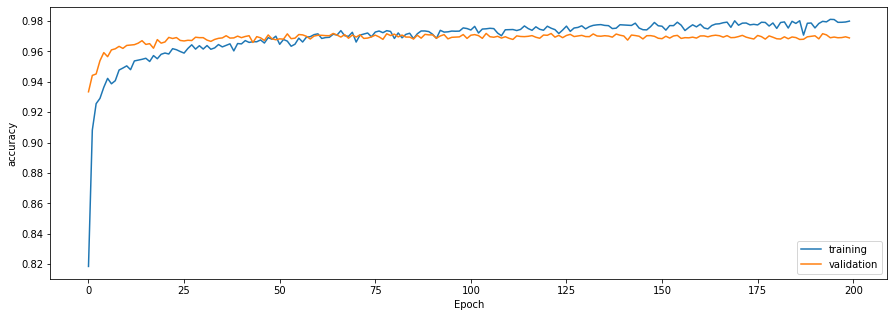

In [46]:
# 모델 성능 시각화
plt. figure(figsize = (15,5))

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

In [47]:
model_eval = model.evaluate(X_test, y_test)
print(model_eval[1])

313/313 [==============================] - 0s 1ms/step - loss: 0.1190 - accuracy: 0.9741
0.9740999937057495


### 학습된 모델을 통해서 값 예측

In [48]:
y_pred = model.predict(X_test)
y_pred.shape

(10000, 10)

In [49]:
y_pred[0]

array([3.3432506e-09, 1.7465870e-06, 8.5683178e-07, 1.0794777e-05,
       4.2392753e-07, 1.6535510e-07, 5.0158174e-13, 9.9998176e-01,
       3.3099272e-09, 4.2014281e-06], dtype=float32)

In [50]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [51]:
arg_y_pred = np.argmax(y_pred[0])
arg_y_pred

7

## Ensemble

In [52]:
def get_mnist_ensemble_model():
  model = Sequential()

  model.add( Dense(50, activation = 'sigmoid', input_shape = (784, )) ) # 입력층

  model.add(Dense(50, activation = 'sigmoid')) # 은닉층1
  model.add(Dense(50, activation = 'sigmoid')) # 은닉층2
  model.add(Dense(50, activation = 'sigmoid'))  # 은닉층3
  
  model.add( Dense(10, activation = 'softmax' )) # 출력층

  model.compile(optimizer = Adam(learning_rate=0.01),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])
  
  return model

In [53]:
# keras 사용해서 모델생성
model01 = KerasClassifier(build_fn=get_mnist_ensemble_model, epochs=100, verbose=0)
model02 = KerasClassifier(build_fn=get_mnist_ensemble_model, epochs=100, verbose=0)
model03 = KerasClassifier(build_fn=get_mnist_ensemble_model, epochs=100, verbose=0)

model01._estimator_type ='classifier'
model02._estimator_type ='classifier'
model03._estimator_type ='classifier'


In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000, 10), (10000, 10))

In [57]:
# keras 사용!
y_train = np.argmax( y_train , axis = 1)
y_test = np.argmax( y_test, axis = 1) 
final_model = VotingClassifier(estimators=[('model01',model01),('model02',model02),('model03',model03)],voting='soft')
final_model.fit(X_train, y_train)


VotingClassifier(estimators=[('model01',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f668b53d510>),
                             ('model02',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f668b53d5d0>),
                             ('model03',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f668b53d650>)],
                 flatten_transform=True, n_jobs=None, voting='soft',
                 weights=None)

In [58]:
y_pred = final_model.predict(X_test)
print('Test accuracy : ', accuracy_score(y_pred, y_test))

Test accuracy :  0.8606
